In [1]:
from mandala._next.imports import *

storage = Storage(
    # omit for an in-memory storage
    db_path='my_persistent_storage.db', 
    # omit to disable automatic dependency tracking
    # use "__main__" to only track functions defined in the current session
    deps_path='__main__', 
)

In [2]:
from sklearn.datasets import load_digits

@op 
def load_data(n_class=2):
    return load_digits(n_class=n_class, return_X_y=True)

with storage:
    X, y = load_data()
    print(X)

AtomRef(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  1., ...,  3.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  8.,  1.,  0.],
       [ 0.,  0.,  6., ...,  4.,  0.,  0.],
       [ 0.,  0.,  6., ...,  6.,  0.,  0.]]), hid='16e...', cid='908...')


In [3]:
with storage:
    X, y = load_data()
    print(X)

AtomRef(hid='16e...', cid='908...', in_memory=False)


In [4]:
storage.unwrap(X)

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  1., ...,  3.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  8.,  1.,  0.],
       [ 0.,  0.,  6., ...,  4.,  0.,  0.],
       [ 0.,  0.,  6., ...,  6.,  0.,  0.]])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### new ops to train an ML model and evaluate
@op
def train_model(X, y, n_estimators=5):
    return RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=2).fit(X, y)

@op
def get_acc(model, X, y):
    return round(accuracy_score(y_pred=model.predict(X), y_true=y), 2)

### iterate on saved results by just dumping more computations on top
with storage:
    for n_class in (2, 5,):
        X, y = load_data(n_class) 
        for n_estimators in (5, 10):
            model = train_model(X, y, n_estimators=n_estimators)
            acc = get_acc(model, X, y)
            print(acc)

AtomRef(1.0, hid='146...', cid='b67...')
AtomRef(1.0, hid='60f...', cid='b67...')
AtomRef(0.88, hid='178...', cid='6e9...')
AtomRef(0.9, hid='01e...', cid='24c...')


In [6]:
# use composable memoization as imperative computation+query interface
with storage:
    X, y = load_data(5)
    for n_estimators in (5, 20):
        model = train_model(X, y, n_estimators=n_estimators)
        acc = get_acc(model, X, y)
        print(storage.unwrap(acc))

0.85
0.9


1 1
1 1


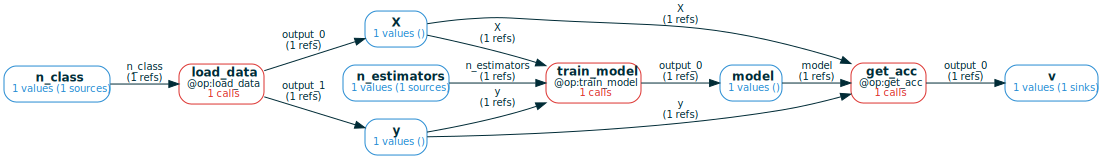

In [12]:
cf = storage.cf(acc).expand_back(reuse_existing=True); cf.draw(verbose=True, orientation='LR', path='readme_cf.svg')

In [17]:
with storage:
    accs = []
    models = []
    for n_class in (2, 5,):
        X, y = load_data(n_class) 
        for n_estimators in (5, 10):
            model = train_model(X, y, n_estimators=n_estimators)
            acc = get_acc(model, X, y)
            models.append(model)
            accs.append(acc)

4 4
2 2
2 2


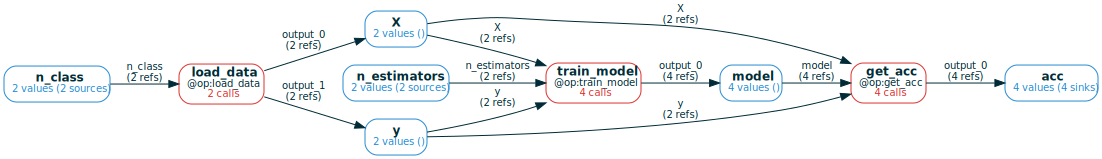

Extracting tuples from the computation graph:
    (X)@output_0, (y)@output_1 = load_data(n_class=n_class)
    (model)@output_0 = train_model(X=X, y=y, n_estimators=n_estimators)
    (acc)@output_0 = get_acc(model=model, X=X, y=y)
|    |   n_estimators |   n_class | load_data                                   | train_model                                   | model                                                | get_acc                                   |   acc |
|---:|---------------:|----------:|:--------------------------------------------|:----------------------------------------------|:-----------------------------------------------------|:------------------------------------------|------:|
|  0 |              5 |         2 | Call(load_data, cid='7e4...', hid='9e5...') | Call(train_model, cid='b39...', hid='bab...') | RandomForestClassifier(max_depth=2, n_estimators=5)  | Call(get_acc, cid='d87...', hid='c4c...') |  1    |
|  1 |              5 |         5 | Call(load_data, cid='6e

In [24]:
cf = storage.cf({'acc': accs, 'model': models}).expand()
cf.draw(verbose=True, orientation='LR', path='readme_cf2.svg')
print(cf.df().drop(columns=['X', 'y']).to_markdown())

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Any

N_CLASS = 10

@track # to track a non-memoized function as a dependency
def scale_data(X):
    return StandardScaler(with_mean=True, with_std=False).fit_transform(X)

@op
def load_data():
    X, y = load_digits(n_class=N_CLASS, return_X_y=True)
    return X, y

@op
def train_model(X, y, scale=False):
    if scale:
        X = scale_data(X)
    return LogisticRegression().fit(X, y)

@op
def eval_model(model, X, y, scale=False):
    if scale:
        X = scale_data(X)
    return model.score(X, y)

storage = Storage(deps_path='__main__')

with storage:
    X, y = load_data()
    for scale in [False, True]:
        model = train_model(X, y, scale=scale)
        acc = eval_model(model, X, y, scale=scale)